<a href="https://colab.research.google.com/github/CIA-Oceanix/DLGD2021/blob/main/lecture-5-inverse-problems/notebookPyTorch_InvProb_LearningBased_4DVarNet_L63.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import tensorflow.keras as keras

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition
from sklearn.feature_extraction import image


In [2]:
!pip install pytorch_lightning

     |████████████████████████████████| 524 kB 5.5 MB/s 
     |████████████████████████████████| 132 kB 49.2 MB/s 
     |████████████████████████████████| 332 kB 44.0 MB/s 
     |████████████████████████████████| 829 kB 33.5 MB/s 
     |████████████████████████████████| 596 kB 42.6 MB/s 
     |████████████████████████████████| 1.1 MB 36.1 MB/s 
     |████████████████████████████████| 160 kB 46.1 MB/s 
     |████████████████████████████████| 271 kB 52.6 MB/s 
     |████████████████████████████████| 192 kB 51.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=8040f3096ad82ba3818b28eadd3b7c42d4da4268c207fa9f78c4c922605893b7
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [3]:
os.mkdir('/content/PythonCode')
os.chdir('/content/PythonCode/')
!git clone https://github.com/CIA-Oceanix/DLGD2021.git

Cloning into 'DLGD2021'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (278/278), done.
remote: Total 301 (delta 141), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (301/301), 101.86 MiB | 16.60 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [4]:
os.chdir('/content/PythonCode/DLGD2021/lecture-5-inverse-problems')
import solver as solver_4DVarNet

In [5]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/4dvarnet')
!pwd

Mounted at /content/drive
/content/drive/My Drive/4dvarnet


# L63 Data simulation

........ Data generation
........ Random seed set to 100
(20000, 3)


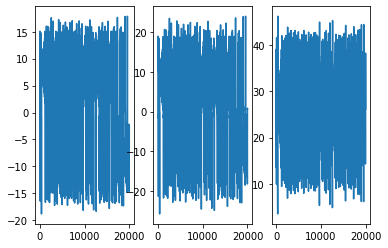

In [6]:
#os.chdir('/content/drive/My Drive/Colab Notebooks/AnDA')
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
#from AnDA_codes.AnDA_dynamical_models import AnDA_Lorenz_63, AnDA_Lorenz_96

print('........ Data generation')
flagRandomSeed = 0
if flagRandomSeed == 0:
    print('........ Random seed set to 100')
    np.random.seed(100)
    torch.manual_seed(100)

def AnDA_Lorenz_63(S,t,sigma,rho,beta):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0]);
    x_2 = S[0]*(rho-S[2])-S[1];
    x_3 = S[0]*S[1] - beta*S[2];
    dS  = np.array([x_1,x_2,x_3]);
    return dS

class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho   = 28.0
        beta  = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8 # number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1,2]) # indices of the observed variables
    nb_loop_train = 10**2 # size of the catalog
    nb_loop_test = 20000 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation

class time_series:
  values = 0.
  time   = 0.
  
## data generation: L63 series
GD = GD()    
y0 = np.array([8.0,0.0,30.0])
tt = np.arange(GD.dt_integration,GD.nb_loop_test*GD.dt_integration+0.000001,GD.dt_integration)
#S = odeint(AnDA_Lorenz_63,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta));
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[0.,5+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=np.arange(0,5+0.000001,GD.dt_integration),method='RK45')

y0 = S.y[:,-1];
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[GD.dt_integration,GD.nb_loop_test+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()


print(S.shape)
plt.figure(1)
for jj in range(0,3):
  plt.subplot(131+jj)
  plt.plot(S[:,jj])
  
class time_series:
  values = 0.
  time   = 0.
  
xt = time_series()
xt.values = S
xt.time   = tt

In [7]:
####################################################
## Generation of training and test dataset
## Extraction of time series of dT time steps            
NbTraining = 10000
NbTest     = 2000#256
time_step = 1
dT        = 200
sigNoise  = np.sqrt(2.0)
rateMissingData = (1-1./8.)#0.75#0.95
  
xt = time_series()
xt.values = S
xt.time   = tt
# extract subsequences
dataTrainingNoNaN = image.extract_patches_2d(xt.values[0:12000:time_step,:],(dT,3),max_patches=NbTraining)
dataTestNoNaN     = image.extract_patches_2d(xt.values[15000::time_step,:],(dT,3),max_patches=NbTest)

# create missing data
flagTypeMissData = 2
if flagTypeMissData == 0:
    print('..... Observation pattern: Random sampling of osberved L63 components')
    indRand         = np.random.permutation(dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTraining    = np.copy(dataTrainingNoNaN).reshape((dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2],1))
    dataTraining[indRand] = float('nan')
    dataTraining    = np.reshape(dataTraining,(dataTrainingNoNaN.shape[0],dataTrainingNoNaN.shape[1],dataTrainingNoNaN.shape[2]))
    
    indRand         = np.random.permutation(dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTest        = np.copy(dataTestNoNaN).reshape((dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2],1))
    dataTest[indRand] = float('nan')
    dataTest          = np.reshape(dataTest,(dataTestNoNaN.shape[0],dataTestNoNaN.shape[1],dataTestNoNaN.shape[2]))

    genSuffixObs    = '_ObsRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
elif flagTypeMissData == 2:
    print('..... Observation pattern: Only the first L63 component is osberved')
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTraining    = np.zeros((dataTrainingNoNaN.shape))
    dataTraining[:] = float('nan')
    dataTraining[:,::time_step_obs,0] = dataTrainingNoNaN[:,::time_step_obs,0]
    
    dataTest    = np.zeros((dataTestNoNaN.shape))
    dataTest[:] = float('nan')
    dataTest[:,::time_step_obs,0] = dataTestNoNaN[:,::time_step_obs,0]

    genSuffixObs    = '_ObsDim0_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
   
else:
    print('..... Observation pattern: All  L63 components osberved')
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTraining    = np.zeros((dataTrainingNoNaN.shape))
    dataTraining[:] = float('nan')
    dataTraining[:,::time_step_obs,:] = dataTrainingNoNaN[:,::time_step_obs,:]
    
    dataTest    = np.zeros((dataTestNoNaN.shape))
    dataTest[:] = float('nan')
    dataTest[:,::time_step_obs,:] = dataTestNoNaN[:,::time_step_obs,:]

    genSuffixObs    = '_ObsSub_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    
# set to NaN patch boundaries
dataTraining[:,0:10,:] =  float('nan')
dataTest[:,0:10,:]     =  float('nan')
dataTraining[:,dT-10:dT,:] =  float('nan')
dataTest[:,dT-10:dT,:]     =  float('nan')

# mask for NaN
maskTraining = (dataTraining == dataTraining).astype('float')
maskTest     = ( dataTest    ==  dataTest   ).astype('float')

dataTraining = np.nan_to_num(dataTraining)
dataTest     = np.nan_to_num(dataTest)

# Permutation to have channel as #1 component
dataTraining      = np.moveaxis(dataTraining,-1,1)
maskTraining      = np.moveaxis(maskTraining,-1,1)
dataTrainingNoNaN = np.moveaxis(dataTrainingNoNaN,-1,1)

dataTest      = np.moveaxis(dataTest,-1,1)
maskTest      = np.moveaxis(maskTest,-1,1)
dataTestNoNaN = np.moveaxis(dataTestNoNaN,-1,1)

# set to NaN patch boundaries
#dataTraining[:,0:5,:] =  dataTrainingNoNaN[:,0:5,:]
#dataTest[:,0:5,:]     =  dataTestNoNaN[:,0:5,:]

############################################
## raw data
X_train         = dataTrainingNoNaN
X_train_missing = dataTraining
mask_train      = maskTraining

X_test         = dataTestNoNaN
X_test_missing = dataTest
mask_test      = maskTest

############################################
## normalized data
meanTr          = np.mean(X_train_missing[:]) / np.mean(mask_train) 
stdTr           = np.sqrt( np.mean( (X_train_missing-meanTr)**2 ) / np.mean(mask_train) )

if flagTypeMissData == 2:
    meanTr          = np.mean(X_train[:]) 
    stdTr           = np.sqrt( np.mean( (X_train-meanTr)**2 ) )

x_train_missing = ( X_train_missing - meanTr ) / stdTr
x_test_missing  = ( X_test_missing - meanTr ) / stdTr

# scale wrt std

x_train = (X_train - meanTr) / stdTr
x_test  = (X_test - meanTr) / stdTr

print('.... MeanTr = %.3f --- StdTr = %.3f '%(meanTr,stdTr))

# Generate noisy observsation
X_train_obs = X_train_missing + sigNoise * maskTraining * np.random.randn(X_train_missing.shape[0],X_train_missing.shape[1],X_train_missing.shape[2])
X_test_obs  = X_test_missing  + sigNoise * maskTest * np.random.randn(X_test_missing.shape[0],X_test_missing.shape[1],X_test_missing.shape[2])

x_train_obs = (X_train_obs - meanTr) / stdTr
x_test_obs  = (X_test_obs - meanTr) / stdTr

print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


..... Observation pattern: Only the first L63 component is osberved
.... MeanTr = 8.435 --- StdTr = 13.687 
..... Training dataset: 10000x3x200
..... Test dataset    : 2000x3x200


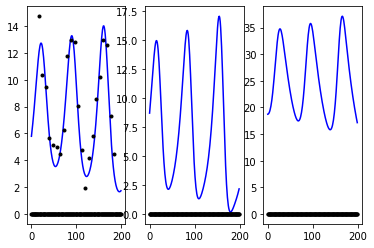

In [8]:
# Visualisation
plt.figure(1)
for jj in range(0,3):
  indjj = 131+jj
  plt.subplot(indjj)
  plt.plot(X_train[20,jj,:],'b-')
  plt.plot(X_train_obs[20,jj,:],'k.')

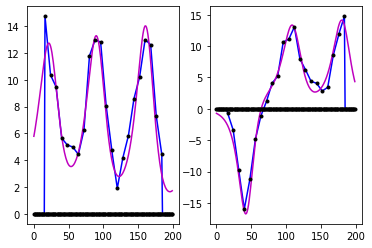

In [9]:
# Initial interpolation (linear interpolation or zeros) for missing data

import scipy

mx_train = np.sum( np.sum( X_train , axis = 2 ) , axis = 0 ) / (X_train.shape[0]*X_train.shape[2])

flagInit = 1

if flagInit == 0: 
  X_train_Init = mask_train * X_train_obs + (1. - mask_train) * (np.zeros(X_train_missing.shape) + meanTr)
  X_test_Init  = mask_test * X_test_obs + (1. - mask_test) * (np.zeros(X_test_missing.shape) + meanTr)
else:
  X_train_Init = np.zeros(X_train.shape)
  for ii in range(0,X_train.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_train.shape[1],X_train.shape[2]))

    for kk in range(0,3):
      indt  = np.where( mask_train[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_train[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_train_obs[ii,kk,indt])
        XInit[kk,indt]  = X_train_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit[kk,:] = XInit[kk,:] + mx_train[kk]

    X_train_Init[ii,:,:] = XInit

  X_test_Init = np.zeros(X_test.shape)
  for ii in range(0,X_test.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_test.shape[1],X_test.shape[2]))

    for kk in range(0,3):
      indt  = np.where( mask_test[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_test[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_test_obs[ii,kk,indt])
        XInit[kk,indt]  = X_test_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit[kk,:] = XInit[kk,:] + mx_train[kk]

    X_test_Init[ii,:,:] = XInit


x_train_Init = ( X_train_Init - meanTr ) / stdTr
x_test_Init = ( X_test_Init - meanTr ) / stdTr


if 1*1:
  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(X_train_Init[20,0,:],'b-')
  plt.plot(X_train[20,0,:],'m-')
  #plt.plot(XInit[:,0],'r-')
  plt.plot(X_train_obs[20,0,:],'k.')
  plt.subplot(1,2,2)
  plt.plot(X_test_Init[20,0,:],'b-')
  plt.plot(X_test[20,0,:],'m-')
  #plt.plot(XInit[:,0],'r-')
  plt.plot(X_test_obs[20,0,:],'k.')

In [10]:
# reshape to 2D tensors to use 
# the 2D implementation of the 4DVarNet
x_train = x_train.reshape((-1,3,dT,1))
mask_train = mask_train.reshape((-1,3,dT,1))
x_train_Init = x_train_Init.reshape((-1,3,dT,1))
x_train_obs = x_train_obs.reshape((-1,3,dT,1))

x_test = x_test.reshape((-1,3,dT,1))
mask_test = mask_test.reshape((-1,3,dT,1))
x_test_Init = x_test_Init.reshape((-1,3,dT,1))
x_test_obs = x_test_obs.reshape((-1,3,dT,1))

print('..... Training dataset: %dx%dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2],x_train.shape[3]))
print('..... Test dataset    : %dx%dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2],x_test.shape[3]))

..... Training dataset: 10000x3x200x1
..... Test dataset    : 2000x3x200x1


# Trainable dynamical prior $\Phi$



In [11]:
flagAEType = 'unet'
DimAE = 10
shapeData  = x_train.shape[1:]

if flagAEType == 'ode': ## ode_L63

    class Phi_r(torch.nn.Module):
        def __init__(self):
              super(Phi_r, self).__init__()
              self.sigma = torch.nn.Parameter(torch.Tensor([np.random.randn()]))
              self.rho    = torch.nn.Parameter(torch.Tensor([np.random.randn()]))
              self.beta   = torch.nn.Parameter(torch.Tensor([np.random.randn()]))

              self.sigma  = torch.nn.Parameter(torch.Tensor([10.]))
              self.rho    = torch.nn.Parameter(torch.Tensor([28.]))
              self.beta   = torch.nn.Parameter(torch.Tensor([8./3.]))

              self.dt        = 0.01
              self.IntScheme = 'rk4'
              self.stdTr     = stdTr
              self.meanTr    = meanTr                      
        def _odeL63(self, xin):
            x1  = xin[:,0,:]
            x2  = xin[:,1,:]
            x3  = xin[:,2,:]
            
            dx_1 = (self.sigma*(x2-x1)).view(-1,1,xin.size(2))
            dx_2 = (x1*(self.rho-x3)-x2).view(-1,1,xin.size(2))
            dx_3 = (x1*x2 - self.beta*x3).view(-1,1,xin.size(2))
            
            dpred = torch.cat((dx_1,dx_2,dx_3),dim=1)
            return dpred

        def _EulerSolver(self, x):
            return x + self.dt * self._odeL63(x)

        def _RK4Solver(self, x):
            k1 = self._odeL63(x)
            x2 = x + 0.5 * self.dt * k1
            k2 = self._odeL63(x2)
          
            x3 = x + 0.5 * self.dt * k2
            k3 = self._odeL63(x3)
              
            x4 = x + self.dt * k3
            k4 = self._odeL63(x4)

            return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.
      
        def forward(self, x):
            X = self.stdTr * x.view(-1,x.size(1),x.size(2))
            X = X + self.meanTr
            
            if self.IntScheme == 'euler':
                xpred = self._EulerSolver( X[:,:,0:x.size(2)-1] )
            else:
                xpred = self._RK4Solver( X[:,:,0:x.size(2)-1] )

            xpred = xpred - self.meanTr
            xpred = xpred / self.stdTr

            xnew  = torch.cat((x[:,:,0].view(-1,x.size(1),1),xpred),dim=2)
            
            xnew = xnew.view(-1,x.size(1),x.size(2),1)
            
            return xnew

elif flagAEType == 'unet': ## Conv model with no use of the central point
  dW = 5
  class Phi_r(torch.nn.Module):
      def __init__(self):
          super(Phi_r, self).__init__()
          self.pool1  = torch.nn.AvgPool2d((4,1))
          #self.conv1  = ConstrainedConv2d(shapeData[0],2*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
          self.conv1  = torch.nn.Conv2d(shapeData[0],2*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
          self.conv2  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
          self.conv21 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv22 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv23 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv3  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)

          self.conv2Tr = torch.nn.ConvTranspose2d(shapeData[0]*DimAE,shapeData[0],(4,1),stride=(4,1),bias=False)          
          #self.conv5 = torch.nn.Conv1d(2*shapeData[0]*DimAE,2*shapeData[0]*DimAE,3,padding=1,bias=False)
          #self.conv6 = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)

          #self.convHR1  = ConstrainedConv2d(shapeData[0],2*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
          #self.convHR1  = ConstrainedConv2d(shapeData[0],2*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
          self.convHR1  = torch.nn.Conv2d(shapeData[0],2*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
          self.convHR2  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
          self.convHR21 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.convHR22 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.convHR23 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.convHR3  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)

      def forward(self, xinp):
          #x = self.fc1( torch.nn.Flatten(x) )
          #x = self.pool1( xinp )
          x = self.pool1( xinp )
          x = self.conv1( x )
          x = self.conv2( F.relu(x) )
          x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x = self.conv3( x )
          x = self.conv2Tr( x )
          #x = self.conv5( F.relu(x) )
          #x = self.conv6( F.relu(x) )
          
          xHR = self.convHR1( xinp )
          xHR = self.convHR2( F.relu(xHR) )
          xHR = torch.cat((self.convHR21(xHR), self.convHR22(xHR) * self.convHR23(xHR)),dim=1)
          xHR = self.convHR3( xHR )
          
          x   = torch.add(x,1.,xHR)
          
          x = x.view(-1,shapeData[0],shapeData[1],1)
          return x


# Observation model

In [12]:
# Observation model
class Model_H(torch.nn.Module):
    def __init__(self):
        super(Model_H, self).__init__()
        #self.DimObs = 1
        #self.dimObsChannel = np.array([shapeData[0]])
        self.dim_obs = 1
        self.dim_obs_channel = np.array([shapeData[0]])

        self.DimObs = 1
        self.dimObsChannel = np.array([shapeData[0]])

    def forward(self, x, y, mask):
        dyout = (x - y) * mask
        return dyout

# Lightning Class for 4DVarNet

In [13]:
class HParam:
    def __init__(self):
        self.iter_update     = []
        self.nb_grad_update  = []
        self.lr_update       = []
        self.n_grad          = 1
        self.dim_grad_solver = 10
        self.dropout         = 0.25
        self.w_loss          = []
        self.automatic_optimization = True

        self.alpha_proj    = 0.5
        self.alpha_mse = 10.

        self.k_batch = 1

In [14]:
EPS_NORM_GRAD = 0. * 1.e-20  
import pytorch_lightning as pl

class LitModel(pl.LightningModule):
    def __init__(self,conf=HParam(),*args, **kwargs):
        super().__init__()
        self.save_hyperparameters()

        # hyperparameters
        self.hparams.iter_update     = [0, 20, 50, 70, 100, 150, 800]  # [0,2,4,6,9,15]
        self.hparams.nb_grad_update  = [5, 5, 10, 10, 15, 15, 20, 20, 20]  # [0,0,1,2,3,3]#[0,2,2,4,5,5]#
        self.hparams.lr_update       = [1e-3, 1e-4, 1e-4, 1e-5, 1e-4, 1e-5, 1e-5, 1e-6, 1e-7]
        
        self.hparams.n_grad          = self.hparams.nb_grad_update[0]
        self.hparams.k_n_grad        = 1
        self.hparams.dim_grad_solver = dimGradSolver
        self.hparams.dropout         = rateDropout
        
        self.hparams.k_batch         = 1
        
        self.hparams.alpha_prior    = 0.5
        self.hparams.alpha_mse = 1.e1        

        self.hparams.w_loss          = torch.nn.Parameter(torch.Tensor(w_loss), requires_grad=False)
        self.hparams.automatic_optimization = False#True#

        # main model
        self.model        = solver_4DVarNet.Solver_Grad_4DVarNN(Phi_r(), 
                                                            Model_H(), 
                                                            solver_4DVarNet.model_GradUpdateLSTM(shapeData, UsePriodicBoundary, self.hparams.dim_grad_solver, self.hparams.dropout), 
                                                            None, None, shapeData, self.hparams.n_grad, EPS_NORM_GRAD)#, self.hparams.eps_norm_grad)
        self.w_loss       = self.hparams.w_loss # duplicate for automatic upload to gpu
        self.x_rec    = None # variable to store output of test method
        self.x_rec_obs = None
        self.curr = 0

        self.automatic_optimization = self.hparams.automatic_optimization
        

    def forward(self):
        return 1

    def configure_optimizers(self):
        optimizer   = optim.Adam([{'params': self.model.model_Grad.parameters(), 'lr': self.hparams.lr_update[0]},
                                      {'params': self.model.model_VarCost.parameters(), 'lr': self.hparams.lr_update[0]},
                                    {'params': self.model.phi_r.parameters(), 'lr': 0.5*self.hparams.lr_update[0]},
                                    ], lr=0.)
        return optimizer
    
    def on_epoch_start(self):
        # enfore acnd check some hyperparameters 
        #self.model.n_grad   = self.hparams.k_n_grad * self.hparams.n_grad 
        self.model.n_grad   = self.hparams.n_grad 
        
    def on_train_epoch_start(self):
        self.model.n_grad   = self.hparams.n_grad 

        opt = self.optimizers()
        if (self.current_epoch in self.hparams.iter_update) & (self.current_epoch > 0):
            indx             = self.hparams.iter_update.index(self.current_epoch)
            print('... Update Iterations number/learning rate #%d: NGrad = %d -- lr = %f'%(self.current_epoch,self.hparams.nb_grad_update[indx],self.hparams.lr_update[indx]))
            
            self.hparams.n_grad = self.hparams.nb_grad_update[indx]
            self.model.n_grad   = self.hparams.n_grad 
            
            mm = 0
            lrCurrent = self.hparams.lr_update[indx]
            lr = np.array([lrCurrent,lrCurrent,0.5*lrCurrent,0.])            
            for pg in opt.param_groups:
                pg['lr'] = lr[mm]# * self.hparams.learning_rate
                mm += 1
        
        #if self.current_epoch == 0 :     
        #    self.save_hyperparameters()
        
    def training_step(self, train_batch, batch_idx, optimizer_idx=0):
        opt = self.optimizers()
                    
        # compute loss and metrics
        loss, out, metrics = self.compute_loss(train_batch, phase='train')
        
        for kk in range(0,self.hparams.k_n_grad-1):
            loss1, out, metrics = self.compute_loss(train_batch, phase='train',batch_init=out[0],hidden=out[1],cell=out[2],normgrad=out[3])
            loss = loss + loss1
        
        # log step metric        
        #self.log('train_mse', mse)
        #self.log("dev_loss", mse / var_Tr , on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        #self.log("loss", loss , on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("tr_mse", stdTr**2 * metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        
        # initial grad value
        if self.hparams.automatic_optimization == False :
            # backward
            self.manual_backward(loss)
        
            if (batch_idx + 1) % self.hparams.k_batch == 0:
                # optimisation step
                opt.step()
                
                # grad initialization to zero
                opt.zero_grad()
         
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        loss, out, metrics = self.compute_loss(val_batch, phase='val')
        for kk in range(0,self.hparams.k_n_grad-1):
            loss1, out, metrics = self.compute_loss(val_batch, phase='val',batch_init=out[0],hidden=out[1],cell=out[2],normgrad=out[3])
            loss = loss1

        #self.log('val_loss', loss)
        self.log('val_loss', stdTr**2 * metrics['mse'] )
        self.log("val_mse", stdTr**2 * metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def test_step(self, test_batch, batch_idx):
        loss, out, metrics = self.compute_loss(test_batch, phase='test')
        
        for kk in range(0,self.hparams.k_n_grad-1):
            loss1, out, metrics = self.compute_loss(test_batch, phase='test',batch_init=out[0].detach(),hidden=out[1],cell=out[2],normgrad=out[3])

        #out_ssh,out_ssh_obs = out
        #self.log('test_loss', loss)
        self.log("test_mse", stdTr**2 * metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        #return {'preds': out_ssh.detach().cpu(),'obs_ssh': out_ssh_obs.detach().cpu()}
        return {'preds': out[0].detach().cpu()}

    #def training_epoch_end(self, training_step_outputs):
        # do something with all training_step outputs
    #    return 1
    def test_epoch_end(self, outputs):
        x_test_rec = torch.cat([chunk['preds'] for chunk in outputs]).numpy()
        x_test_rec = stdTr * x_test_rec + meanTr        
        self.x_rec = x_test_rec.squeeze()

        return [{'mse':0.,'preds': 0.}]

    def compute_loss(self, batch, phase, batch_init = None , hidden = None , cell = None , normgrad = 0.0):

        inputs_init_,inputs_obs,masks,targets_GT = batch
 
        #inputs_init = inputs_init_
        if batch_init is None :
            inputs_init = inputs_init_
        else:
            inputs_init = batch_init
            
        if phase == 'train' :                
            inputs_init = inputs_init.detach()
            
        with torch.set_grad_enabled(True):
            # with torch.set_grad_enabled(phase == 'train'):
            inputs_init = torch.autograd.Variable(inputs_init, requires_grad=True)

            #outputs, hidden_new, cell_new, normgrad_ = self.model(inputs_init_, inputs_obs, masks)#,hidden = hidden , cell = cell , normgrad = normgrad)
            #outputs, hidden_new, cell_new, normgrad_ = self.model(inputs_init, inputs_obs, masks ,hidden = None , cell = None , normgrad = normgrad )
            outputs, hidden_new, cell_new, normgrad_ = self.model(inputs_init, inputs_obs, masks, hidden = hidden , cell = cell , normgrad = normgrad )

            #loss_mse   = solver_4DVarNet.compute_WeightedLoss((outputs - targets_GT), self.w_loss)
            loss_mse = torch.mean((outputs - targets_GT) ** 2)
            loss_prior = torch.mean((self.model.phi_r(outputs) - outputs) ** 2)
            loss_prior_gt = torch.mean((self.model.phi_r(targets_GT) - targets_GT) ** 2)

            loss = self.hparams.alpha_mse * loss_mse
            loss += 0.5 * self.hparams.alpha_prior * (loss_prior + loss_prior_gt)
            
            # metrics
            mse       = loss_mse.detach()
            metrics   = dict([('mse',mse)])
            #print(mse.cpu().detach().numpy())
            if (phase == 'val') or (phase == 'test'):                
                outputs = outputs.detach()
        
        out = [outputs,hidden_new, cell_new, normgrad_]
        
        return loss,out, metrics


# Model training 

In [15]:
# Pytorch dataloadzers
from pytorch_lightning.callbacks import ModelCheckpoint

UsePriodicBoundary = False # use a periodic boundary for all conv operators in the gradient model (see torch_4DVarNN_dinAE)
w_loss = np.ones(dT) / np.float(dT)
batch_size = 128
idx_val = x_train.shape[0]-500


training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init[:idx_val:,:,:,:]),torch.Tensor(x_train_obs[:idx_val:,:,:,:]),torch.Tensor(mask_train[:idx_val:,:,:,:]),torch.Tensor(x_train[:idx_val:,:,:,:])) # create your datset
val_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init[idx_val::,:,:,:]),torch.Tensor(x_train_obs[idx_val::,:,:,:]),torch.Tensor(mask_train[idx_val::,:,:,:]),torch.Tensor(x_train[idx_val::,:,:,:])) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
# Training from scratch
dimGradSolver = 25
rateDropout = 0.2
mod = LitModel()

mod.hparams.n_grad          = 10
mod.hparams.k_n_grad        = 2
mod.hparams.iter_update     = [0, 100, 200, 300, 500, 700, 800]  # [0,2,4,6,9,15]
mod.hparams.nb_grad_update  = [5, 5, 5, 5, 15, 15, 20, 20, 20]  # [0,0,1,2,3,3]#[0,2,2,4,5,5]#
mod.hparams.lr_update       = [1e-3, 1e-4, 1e-5, 1e-5, 1e-4, 1e-5, 1e-5, 1e-6, 1e-7]
        
mod.hparams.alpha_prior = 0.1
mod.hparams.alpha_mse = 1.

profiler_kwargs = {'max_epochs': 50 }

suffix_exp = 'exp%02d'%flagTypeMissData
filename_chkpt = 'model-l63-'

filename_chkpt = filename_chkpt+flagAEType+'-'  
    
filename_chkpt = filename_chkpt + suffix_exp +'-Noise%02d'%(sigNoise)
filename_chkpt = filename_chkpt+'-igrad%02d_%02d'%(mod.hparams.n_grad,mod.hparams.k_n_grad)+'-dgrad%d'%dimGradSolver
filename_chkpt = filename_chkpt+'-drop%02d'%(100*rateDropout)

checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath= './resL63/'+suffix_exp,
                                      filename= filename_chkpt + '-{epoch:02d}-{val_loss:.2f}',
                                      save_top_k=3,
                                      mode='min')
trainer = pl.Trainer(gpus=1,  **profiler_kwargs,callbacks=[checkpoint_callback])
trainer.fit(mod, dataloaders['train'], dataloaders['val'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | Solver_Grad_4DVarNN | 40.7 K
----------------------------------------------
40.7 K    Trainable params
200       Non-trainable params
40.9 K    Total params
0.164     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /content/drive/My Drive/4dvarnet/resL63/exp02 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [16]:
# Check saved checlpoints
#!rm -f resL63/exp02/*CNN*
!ls  -al resL63/exp02/*

-rw------- 1 root root 772606 Dec  5 17:36 'resL63/exp02/modelCNN-l63-01exp02-epoch=42-val_loss=9.47.ckpt'
-rw------- 1 root root 772606 Dec  5 17:36 'resL63/exp02/modelCNN-l63-01exp02-epoch=45-val_loss=9.45.ckpt'
-rw------- 1 root root 772859 Dec  5 17:36 'resL63/exp02/modelCNN-l63-01exp02-epoch=49-val_loss=9.46.ckpt'
-rw------- 1 root root 772606 Dec  5 17:25 'resL63/exp02/modelCNN-l63-exp02-epoch=47-val_loss=6.27.ckpt'
-rw------- 1 root root 772606 Dec  1 15:19 'resL63/exp02/modelCNN-l63-exp02-epoch=47-val_loss=9.36.ckpt'
-rw------- 1 root root 772606 Dec  5 17:32 'resL63/exp02/modelCNN-l63-exp02-epoch=47-val_loss=9.51.ckpt'
-rw------- 1 root root 772606 Dec  5 17:25 'resL63/exp02/modelCNN-l63-exp02-epoch=48-val_loss=6.25.ckpt'
-rw------- 1 root root 772859 Dec  1 15:19 'resL63/exp02/modelCNN-l63-exp02-epoch=48-val_loss=9.40.ckpt'
-rw------- 1 root root 772859 Dec  5 17:32 'resL63/exp02/modelCNN-l63-exp02-epoch=48-val_loss=9.60.ckpt'
-rw------- 1 root root 772859 Dec  5 17:25 'resL6

In [23]:
# Fine-tuning from pre-trained model (checkpoint)
pathCheckPOint = './resL63/exp02/model-l63-unet-exp02-Noise01-igrad05_01-dgrad25-drop20-epoch=48-val_loss=1.80.ckpt'
pathCheckPOint = './resL63/exp02/model-l63-exp02-igrad05_02-dgrad25-drop_20-epoch=74-val_loss=1.49.ckpt'

print('.... load pre-trained model :'+pathCheckPOint)
mod = LitModel.load_from_checkpoint(pathCheckPOint)

mod.hparams.n_grad          = 10
mod.hparams.k_n_grad        = 2
mod.hparams.iter_update     = [0, 100, 200, 300, 500, 700, 800]  # [0,2,4,6,9,a15]
mod.hparams.nb_grad_update  = [5, 5, 5, 5, 5, 5, 20, 20, 20]  # [0,0,1,2,3,3]#[0,2,2,4,5,5]#
mod.hparams.lr_update       = [1e-4, 1e-5, 1e-6, 1e-5, 1e-4, 1e-5, 1e-5, 1e-6, 1e-7]

mod.hparams.alpha_prior = 0.1
mod.hparams.alpha_mse = 1.

profiler_kwargs = {'max_epochs': 100 }

suffix_exp = 'exp%02d'%flagTypeMissData
filename_chkpt = 'model-l63-'

filename_chkpt = filename_chkpt + suffix_exp
filename_chkpt = filename_chkpt+'-igrad%02d_%02d'%(mod.hparams.n_grad,mod.hparams.k_n_grad)+'-dgrad%d'%dimGradSolver
filename_chkpt = filename_chkpt+'-drop_%02d'%(100*rateDropout)

checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath= './resL63/'+suffix_exp,
                                      filename= filename_chkpt + '-{epoch:02d}-{val_loss:.2f}',
                                      save_top_k=3,
                                      mode='min')
trainer = pl.Trainer(gpus=1,  **profiler_kwargs,callbacks=[checkpoint_callback])
trainer.fit(mod, dataloaders['train'], dataloaders['val'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | Solver_Grad_4DVarNN | 40.7 K
----------------------------------------------
40.7 K    Trainable params
200       Non-trainable params
40.9 K    Total params
0.164     Total estimated model params size (MB)


.... load pre-trained model :./resL63/exp02/model-l63-exp02-igrad05_02-dgrad25-drop_20-epoch=74-val_loss=1.49.ckpt


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /content/drive/My Drive/4dvarnet/resL63/exp02 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Model testing

In [21]:
dimGradSolver = 25
rateDropout = 0.2

pathCheckPOint = './resL63/exp02/model-l63-exp02-igrad05_01-dgrad25-drop_20-epoch=36-val_loss=2.14.ckpt'
pathCheckPOint = './resL63/exp02-2/model-l63-exp02-2-igrad05_02-dgrad25-drop_20-epoch=125-val_loss=0.96.ckpt'
pathCheckPOint = 'resL63/exp02/model-l63-exp02-igrad05_02-dgrad25-drop_20-epoch=74-val_loss=1.49.ckpt'
print('.... load pre-trained model :'+pathCheckPOint)

mod = LitModel.load_from_checkpoint(pathCheckPOint)            

#print(mod.hparams)
mod.hparams.n_grad = 5
mod.hparams.k_n_grad = 2

print(' Ngrad = %d / %d'%(mod.hparams.n_grad,mod.model.n_grad))
#trainer = pl.Trainer(gpus=1, accelerator = "ddp", **profiler_kwargs)

profiler_kwargs = {'max_epochs': 1}
trainer = pl.Trainer(gpus=1,  **profiler_kwargs)

############################################################
# metrics for validation dataset
trainer.test(mod, test_dataloaders=dataloaders['val'])

X_val = X_train[idx_val::,:,:]
mask_val = mask_train[idx_val::,:,:,:].squeeze()
var_val  = np.mean( (X_val - np.mean(X_val,axis=0))**2 )
mse = np.mean( (mod.x_rec-X_val) **2 ) 
mse_i   = np.mean( (1.-mask_val.squeeze()) * (mod.x_rec-X_val) **2 ) / np.mean( (1.-mask_val) )
mse_r   = np.mean( mask_val.squeeze() * (mod.x_rec-X_val) **2 ) / np.mean( mask_val )

nmse = mse / var_val
nmse_i = mse_i / var_val
nmse_r = mse_r / var_val

print("..... Assimilation performance (validation data)")
print(".. MSE ALL.   : %.3f / %.3f"%(mse,nmse))
print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))

trainer.test(mod, test_dataloaders=dataloaders['test'])

############################################################
# metrics for test dataset
var_test  = np.mean( (X_test - np.mean(X_test,axis=0))**2 )
mse = np.mean( (mod.x_rec-X_test) **2 ) 
mse_i   = np.mean( (1.-mask_test.squeeze()) * (mod.x_rec-X_test) **2 ) / np.mean( (1.-mask_test) )
mse_r   = np.mean( mask_test.squeeze() * (mod.x_rec-X_test) **2 ) / np.mean( mask_test )

nmse = mse / var_test
nmse_i = mse_i / var_test
nmse_r = mse_r / var_test

print("..... Assimilation performance (test data)")
print(".. MSE ALL.   : %.3f / %.3f"%(mse,nmse))
print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))        

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:902: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


.... load pre-trained model :resL63/exp02/model-l63-exp02-igrad05_02-dgrad25-drop_20-epoch=74-val_loss=1.49.ckpt
 Ngrad = 5 / 5


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mse': 1.488284707069397}
--------------------------------------------------------------------------------
..... Assimilation performance (validation data)
.. MSE ALL.   : 1.488 / 0.021
.. MSE ObsData: 0.551 / 0.008
.. MSE Interp : 1.524 / 0.021


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mse': 1.6471179723739624}
--------------------------------------------------------------------------------
..... Assimilation performance (test data)
.. MSE ALL.   : 1.647 / 0.023
.. MSE ObsData: 0.579 / 0.008
.. MSE Interp : 1.688 / 0.023


..... Assimilation performance
.. MSE ALL.   : 1.647 / 0.023
.. MSE ObsData: 0.579 / 0.008
.. MSE Interp : 1.688 / 0.023


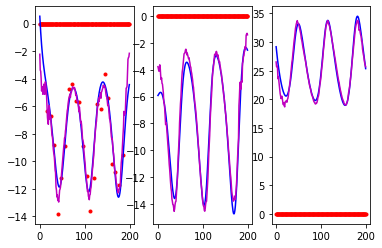

In [22]:
ii = 110

mod.x_rec = mod.x_rec.squeeze()
x_gt  = X_test[ii,:,:]
x_rec = mod.x_rec[ii,:,:]
y_obs = X_test_obs[ii,:,:]

## visualization
plt.figure()
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  plt.plot(y_obs[kk,:],'r.')
  plt.plot(x_gt[kk,:],'b-')
  plt.plot(x_rec[kk,:],'m-')

# Reconstruction performance
var_test  = np.mean( (X_test - np.mean(X_test,axis=0))**2 )
mse = np.mean( (mod.x_rec-X_test) **2 ) 
mse_i   = np.mean( (1.-mask_test.squeeze()) * (mod.x_rec-X_test) **2 ) / np.mean( (1.-mask_test) )
mse_r   = np.mean( mask_test.squeeze() * (mod.x_rec-X_test) **2 ) / np.mean( mask_test )

nmse = mse / var_test
nmse_i   = mse_i / var_test
nmse_r   = mse_r / var_test

print("..... Assimilation performance")
print(".. MSE ALL.   : %.3f / %.3f"%(mse,nmse))
print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))

In [28]:
!ls resL63/exp02-2/

'model-l63-exp02-2-igrad05_01-dgrad25-drop_20-epoch=128-val_loss=1.48.ckpt'
'model-l63-exp02-2-igrad05_01-dgrad25-drop_20-epoch=31-val_loss=2.48.ckpt'
'model-l63-exp02-2-igrad05_02-dgrad25-drop_20-epoch=125-val_loss=0.96.ckpt'
'model-l63-exp02-igrad15_01-dgrad25-drop_00-epoch=93-val_loss=1.18.ckpt'
'model-l63-unet-exp02-2-Noise01-igrad10_02-dgrad25-drop20-epoch=95-val_loss=0.82.ckpt'


In [ ]:
!python main_4DVarNet_L63.py

..... Assimilation performance
.. MSE ALL.   : 0.947 / 0.013 


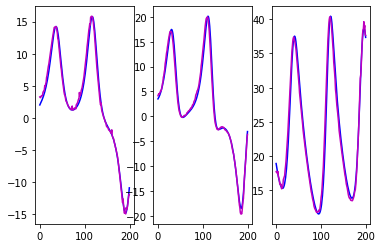

In [44]:
## Load saved results 
from netCDF4 import Dataset

ncfile = Dataset("model-l63-unet-exp02-2-Noise01-igrad10_02-dgrad25-drop20-epoch=95-val_loss=0.82_res.nc","r")
x_gt = ncfile.variables['l63-gt'][:]
x_rec = ncfile.variables['l63-rec'][:]

ii = 100

## visualization
plt.figure()
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  #plt.plot(y_obs[kk,:],'r.')
  plt.plot(x_gt[ii,kk,:].squeeze(),'b-')
  plt.plot(x_rec[ii,kk,:].squeeze(),'m-')

# Reconstruction performance
var_test  = np.mean( (x_gt - np.mean(x_gt,axis=0))**2 )
mse = np.mean( (x_rec-x_gt) **2 ) 
#mse_i   = np.mean( (1.-mask_test.squeeze()) * (mod.x_rec-X_test) **2 ) / np.mean( (1.-mask_test) )
#mse_r   = np.mean( mask_test.squeeze() * (mod.x_rec-X_test) **2 ) / np.mean( mask_test )

nmse = mse / var_test
#nmse_i   = mse_i / var_test
#nmse_r   = mse_r / var_test

print("..... Assimilation performance")
print(".. MSE ALL.   : %.3f / %.3f "%(mse,nmse))
#print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
#print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))


In [ ]:
!ls 